In [1]:
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt
from statsmodels import api as sms

In [2]:
MIN_Y = 75
MAX_Y = 79

yticks_raw = """
104 708 75
106 606 76
104 502 77
103 400 78
106 299 79
"""

xticks_raw = """
104 708 Nov 12
344 708 Nov 13
586 709 Nov 14
827 709 Nov 15
1067 709 Nov 16
"""

with open('points_raw.txt', 'rt') as f:
    points_raw = f.read()

In [3]:
def read_raw_points(lines):
    """
    Read in the points files
    
    Args:
        lines (str): A string consisting of lines whose first
            two elements are integer valued x and y coordinates
            
    Returns:
        np.ndarray: A 2d array of integer points
    """
    points = []
    for row in lines.split('\n'):
        row = row.strip()
        if not row:
            continue
        row = row.split(' ')
        points.append((int(float(row[0])), int(float(row[1]))))
    return np.array(points)

def get_mode(nums):
    """
    Return the modal value of a collection of objects.
    If there are multiple modes, return one of the modes
    
    Args:
        nums (list[object]): A collection of hashable objects
        
    Returns:
        object: an argmax from `nums`
    """
    counter = Counter(nums)
    max_val = max(counter.values())
    argmaxes = [key for key, val in counter.items() if val == max_val]
    return argmaxes[0]

In [4]:
xticks = read_raw_points(xticks_raw)
xdiff = abs(get_mode(np.ediff1d(xticks[:, 0])))

yticks = read_raw_points(yticks_raw)
ydiff = abs(get_mode(np.ediff1d(yticks[:, 1])))

In [5]:
class Scaler1D:
    """
    An object that performs a linear scaling after init.
    Reverses orientation if `reverse == True`.
    """
    def __init__(self, min_x, diff_x, right_x, reverse=False):
        self.min_x = min_x
        self.diff_x = diff_x
        self.right_x = right_x
        self.reverse = -1 if reverse else 1
        
    def __call__(self, x):
        return self.reverse * (x - self.min_x) / self.diff_x + self.right_x

class Scaler:
    """
    A convenience object that multiple scalings
    """
    def __init__(self, *scalers):
        self.scalers = scalers

    def __call__(self, *xs):
        return [scaler(x) for scaler, x in zip(self.scalers, xs)]

In [6]:
x_scaler = Scaler1D(min(tick[0] for tick in xticks), xdiff, 0)
y_scaler = Scaler1D(max(tick[1] for tick in yticks), ydiff, MIN_Y, reverse=True)
scaler = Scaler(x_scaler, y_scaler)

In [7]:
pre_points = read_raw_points(points_raw)
points = np.array([scaler(x, y) for x, y in pre_points])

In [8]:
def monthly_points(points):
    """
    Because the points were gotten by clicking, get the
    mean value near each month to smooth out the
    regression.
    
    Args:
        points (np.ndarray): The points to smooth
        
    Returns:
        np.ndarray: One point for each month
    """
    max_y = np.max(points[:, 1])
    final_points = []
    for true_x in np.arange(0, max_y + 1/12, 1/12):
        ys = [y for x, y in points if abs(x - true_x) < 1/12]
        if ys:
            final_points.append((true_x, sum(ys) / len(ys)))
    return np.array(final_points)

In [9]:
mpoints = monthly_points(points)

In [10]:
def f_from_regress(regress):
    """
    Create a prediction function from a statsmodels fitted
    regression object. Assumes that the 0th coordinate is
    the slope and the 1th coordinate is the intercept
    """
    def f(x):
        return regress.params[0] * x + regress.params[1]
    return f

def add_intercept(x):
    """
    Add a constant to a 1-dimensional numpy array, making it a
    two-dimensional array. Each row is a coordinate, the 0th column
    being x and the 1th column being 1.
    """
    return np.hstack([x[:, np.newaxis], np.ones(shape=(len(x), 1))])

def make_plot_with_cutoff(mpoints, cutoff=0, cutoff_right=16-12, include_error=False):
    """
    Make a plot from a collection of points, assumed to be evenly spaced over the x axis.
    
    Args:
        mpoints (np.ndarray): The points to plot
        cutoff (float): At what x point on the left should we cut off the plot?
            0 corresponds to November 2012, 1 to November 2013, etc.
        cutoff_right (float): Where to cutoff the regression on the right.
            16 - 12 = 4 corresponds to November 2016. Adding or subtracting
            1/12 adds or subtracts a month.
        include_error (bool): Should we plot error bars?
    """
    mpoints = mpoints[mpoints[:, 0] >= cutoff]
    regress_points = mpoints[mpoints[:, 0] <= cutoff_right]
    int_cutoff = int(round(cutoff))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(*zip(*mpoints))
    ax.set_xticks(range(int_cutoff, 7))
    ax.set_xticklabels(['Nov {}'.format(12 + i ) for i in range(int_cutoff, 7)])
    ax.vlines(cutoff_right, MIN_Y, MAX_Y, color='r')
    
    model = sms.OLS(regress_points[:, 1], add_intercept(regress_points[:, 0]))
    fitted = model.fit()
    
    f = f_from_regress(fitted)
    print('Last residual: {}'.format(mpoints[-1, 1] - f(mpoints[-1, 0])))
    ax.plot([0, 6], [f(0), f(6)])
    
    if include_error:
        lower_f = lambda x: fitted.conf_int()[0, 0] * x + fitted.conf_int()[1, 0]
        upper_f = lambda x: fitted.conf_int()[0, 1] * x + fitted.conf_int()[1, 1]
        ax.fill_between([0, 6], [lower_f(0), lower_f(6)], [upper_f(0), upper_f(6)], alpha=0.2, color='b')

    ax.set_xlim([cutoff, 6])
    ax.set_ylim([MIN_Y, MAX_Y])

Last residual: 0.29667803788181857


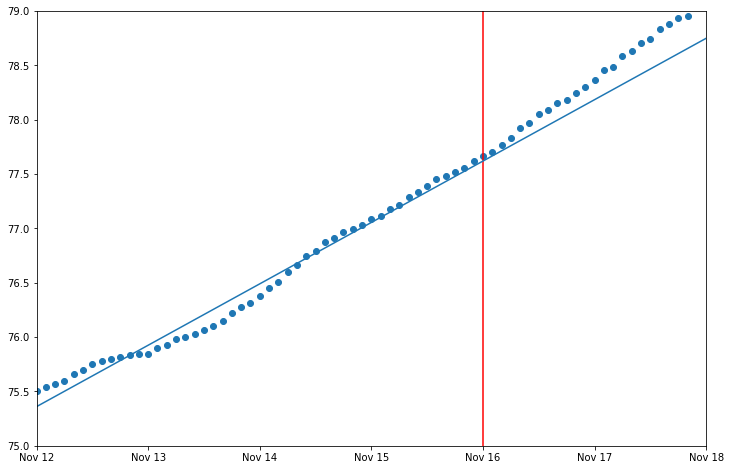

In [11]:
make_plot_with_cutoff(mpoints)

Last residual: 0.29667803788181857


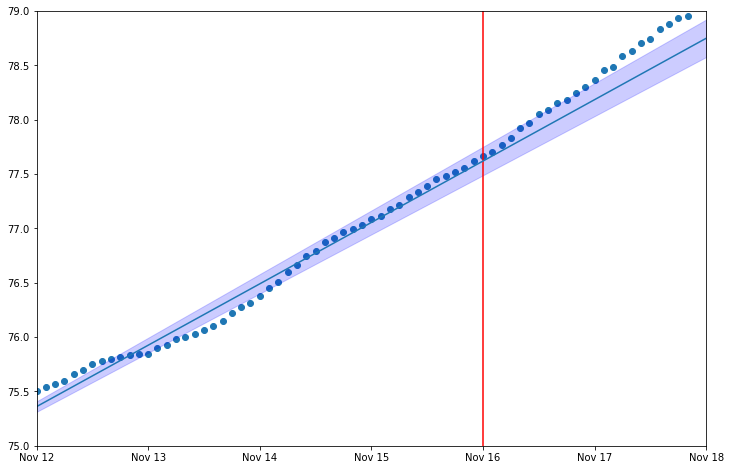

In [12]:
make_plot_with_cutoff(mpoints, include_error=True)

Last residual: 0.08272250578754381


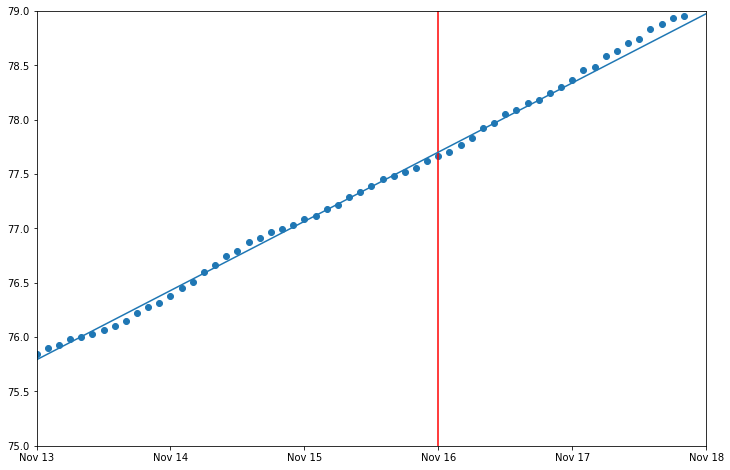

In [13]:
make_plot_with_cutoff(mpoints, cutoff=1)

Last residual: 0.12366264454490761


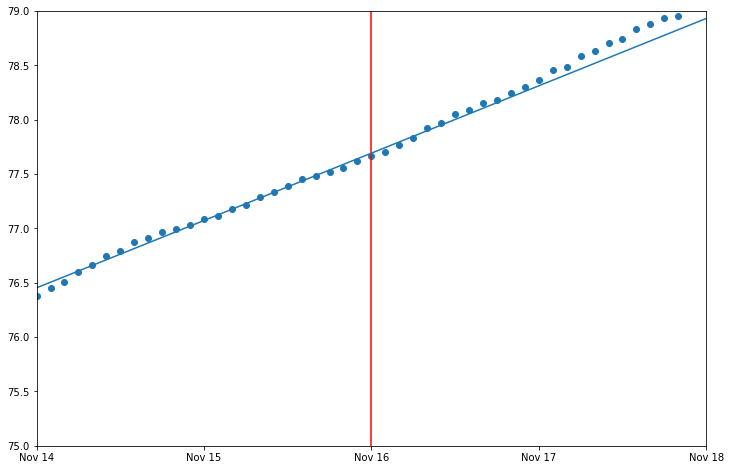

In [14]:
make_plot_with_cutoff(mpoints, cutoff=2)

In [15]:
def find_min_residuals(mpoints, max_cutoff, cutoff_right=16-12):
    """
    Cheat as much as possible by finding the cutoff that minimizes
    the sum of squared residuals to the right of the election.
    """
    min_ssr = float('inf')
    answer = -1
    for cutoff in np.arange(0, max_cutoff, 1/12):
        mpoints = mpoints[mpoints[:, 0] >= cutoff]
        regress_points = mpoints[mpoints[:, 0] <= cutoff_right]
        compare_points = mpoints[mpoints[:, 0] > cutoff_right]
        
        regress = sms.OLS(regress_points[:, 1], add_intercept(regress_points[:, 0]))
        fitted = regress.fit()
        f = f_from_regress(fitted)

        ssr = sum((f(x) - y) ** 2 for x, y in compare_points)
        if ssr < min_ssr:
            answer = cutoff
            min_ssr = ssr
    return answer

In [16]:
find_min_residuals(mpoints, 3)

1.4166666666666665

Last residual: 0.044043794203915354


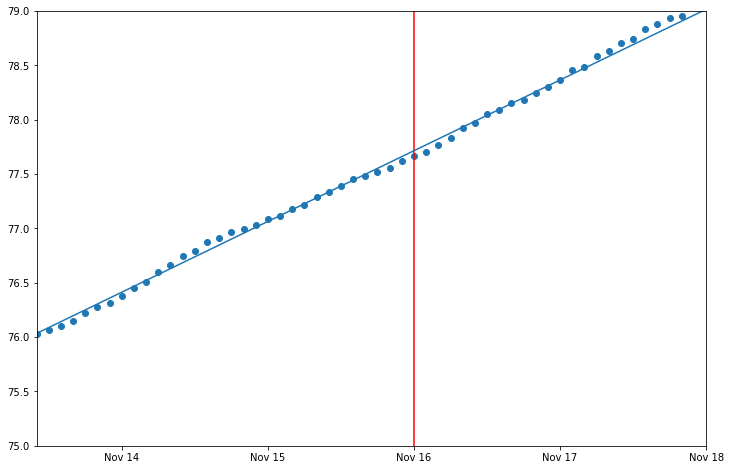

In [17]:
make_plot_with_cutoff(mpoints, find_min_residuals(mpoints, 3))

Last residual: 0.044043794203915354


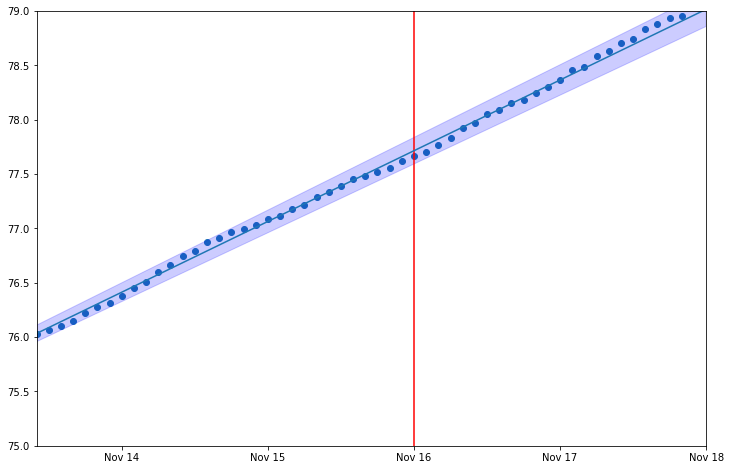

In [18]:
make_plot_with_cutoff(mpoints, find_min_residuals(mpoints, 3), include_error=True)